# SBU CSE 352 - HW 1 -  Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

---

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [2]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'south'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: west
step 1 - action: west
step 2 - action: west
step 3 - action: south
step 4 - action: north
step 5 - action: south
step 6 - action: suck
step 7 - action: south
step 8 - action: south
step 9 - action: east
step 10 - action: north
step 11 - action: south
step 12 - action: east
step 13 - action: east
step 14 - action: suck
step 15 - action: west
step 16 - action: west
step 17 - action: south
step 18 - action: east
step 19 - action: north


2

# Tasks

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design, for example. If it makes your code more simple objects are okay, but try to keep the code as simple as possible.
2. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [30]:
# Your code and description goes here
def simulation_environment(agent, size, max_steps, verbose=True): # assuming the env space is always a square of size x size
  is_clean = False
  perf_measure = 0 # performance measure to be returned
  room = [[False] * size for _ in range(size)] # room matrix to clean (boolean values)
  to_clean = 0 # num of dirty cells to clean
  agent_position = {"row": 0,"column":0}
  bumper_sensors = {"north": True, "west": True, "east": False, "south": False} # initial position is NW corner

  # method to update the agent's sensors according to its position:
  def update_sensors():

    if agent_position["row"] == 0:
      bumper_sensors["north"] = True
      bumper_sensors["south"] = False
    elif agent_position["row"] == 4:
      bumper_sensors["south"] = True
      bumper_sensors["north"] = False
    else:
      bumper_sensors["north"] = False
      bumper_sensors["south"] = False

    if agent_position["column"] == 0:
      bumper_sensors["west"] = True
      bumper_sensors["east"] = False
    elif agent_position["column"] == 4:
      bumper_sensors["east"] = True
      bumper_sensors["west"] = False
    else:
      bumper_sensors["west"] = False
      bumper_sensors["east"] = False

  def update_position(action):
      if action == "north" and not bumper_sensors["north"]:
        agent_position["row"] -= 1
      elif action == "south" and not bumper_sensors["south"]:
        agent_position["row"] += 1
      elif action == "west" and not bumper_sensors["west"]:
        agent_position["column"] -= 1
      elif action == "east" and not bumper_sensors["east"]:
        agent_position["column"] += 1

  # Fill out the room matrix randomly with dirt:
  for i in range(len(room)):
    for j in range(len(room[0])):
      room[i][j] = np.random.choice([True, False]) # make a cell either dirty or not
      if room[i][i] == True:
        to_clean +=1

  i = 0
  if verbose: print("Room to clean:",room)
  if verbose: print("To clean:", to_clean)
  # Start cleaning until the whole room is clean:
  while to_clean > 0 and i < max_steps:
    perf_measure += 1
    action = agent(bumper_sensors, agent_position)
    if verbose:
      print("step",i,":",action)
    i +=1
    if action == "suck":
      room[agent_position["row"]][agent_position["column"]] = False
      to_clean -= 1
    else:
      update_position(action)
    update_sensors()

  return perf_measure

In [26]:
simulation_environment(simple_randomized_agent, 5, 10000) # to test

Room to clean: [[False, False, False, False, False], [False, True, False, False, True], [False, False, False, True, True], [False, True, True, True, False], [True, True, False, True, False]]
To clean: 6
step 0 : north
step 1 : east
step 2 : south
step 3 : west
step 4 : north
step 5 : west
step 6 : west
step 7 : north
step 8 : south
step 9 : east
step 10 : west
step 11 : west
step 12 : north
step 13 : north
step 14 : west
step 15 : west
step 16 : suck
step 17 : north
step 18 : suck
step 19 : south
step 20 : south
step 21 : south
step 22 : suck
step 23 : south
step 24 : south
step 25 : south
step 26 : west
step 27 : east
step 28 : south
step 29 : east
step 30 : south
step 31 : suck
step 32 : north
step 33 : west
step 34 : suck
step 35 : suck


36

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [11]:
# Your code and description goes here
# bumper_sensors = {"north": True, "west": True, "east": False, "south": False}
def reflex_agent(bumpers, dirty):
    actions = ["north", "west", "east", "south"]
    if dirty:
      return "suck"
    else:
      action = np.random.choice(actions)
      while bumpers[action]:
        action = np.random.choice(actions)
    return action

# assuming there is no case when all of the sensors are True

In [12]:
# to test
bumper_sensors = {"north": False, "west": False, "east": False, "south": False}
print(reflex_agent(bumper_sensors, False))

south


## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

Description:
The agent keeps rack of the direction it is supposed to move based in the sensor's infomration: it has indicator for its current mode that depends on if it is located (it is located only after it reaches the South-East corner before taking further actions). Then, it has the indicator of the direcrion it needs to follow: once it is located, it will start moving upwards changing its direction from "west" to "east" reaching iventually one of the rooms top-corners. Once the last corner of the room is reached, the agent's done!
To change the west-east direction, the agent uses its "moving_right" indicator and to locate the last finish corner it uses the bumper sensors informaton and "last_action" indicator".


In [22]:
bumper_sensors = {"north": False, "west": False, "east": False, "south": False}

state = {
    "last_action": None,
    "is_located": False,
    "moving_right": True,
}

def model_based_agent(bumpers, dirty):
  if dirty:
    return "suck"
  # if in the top corner and the previous acton is either "west" or "east":
  # => done !
  if ((bumpers["north"] and bumpers["east"] and state["last_action"] == "east") or
      (bumpers["north"] and bumpers["west"] and state["last_action"] == "west")
     ):
      return "done"

  # STEP 1: Locate South-East Corner:
  if not state["is_located"]:
      if not bumpers["east"]:  # go east
          state["last_action"] = "east"
          return "east"
      elif not bumpers["south"]:  # If east is blocked, move south
          state["last_action"] = "south"
          return "south"
      else:
          # yay, at the SE corner:
          state["is_located"] = True # update the mode
          # Needs to prepare for the  upward zigzag cleaning
          state["moving_right"] = False

  # STEP 2: Upward Zigzag movements:
  # if right direction:
  if state["moving_right"]:
      if not bumpers["east"]:
          state["last_action"] = "east"
          return "east"
      else: # at the east wall:
          state["moving_right"] = False
          return "north" if not bumpers["north"] else "suck"
  else:
      if not bumpers["west"]:
          state["last_action"] = "west"
          return "west"
      else:  # Hit west wall, move up
          state["moving_right"] = True
          return "north" if not bumpers["north"] else "suck"


## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def performance_evaluation(agent_list, sizes=[5, 10, 15], runs= 100, max_steps=100000 ):
    results = {agent.__name__: [] for agent in agent_list}

    for size in sizes:
        for agent in agent_list:
            perf_scores = []
            for _ in range(runs):
                score = simulation_environment(agent, size, max_steps, verbose=False)
                perf_scores.append(score)
            results[agent.__name__].append(np.mean(perf_scores))

    df = pd.DataFrame(results, index=[f"{s}x{s}" for s in sizes])

    return df


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |7.38 |7.37 | 38.75|
| 10x10   |26.50 |28.24 |144.17 |
| 100x100 |59.53 | 56.90| 303.19|

Add charts to compare the performance of the different agents.

Performance Results:


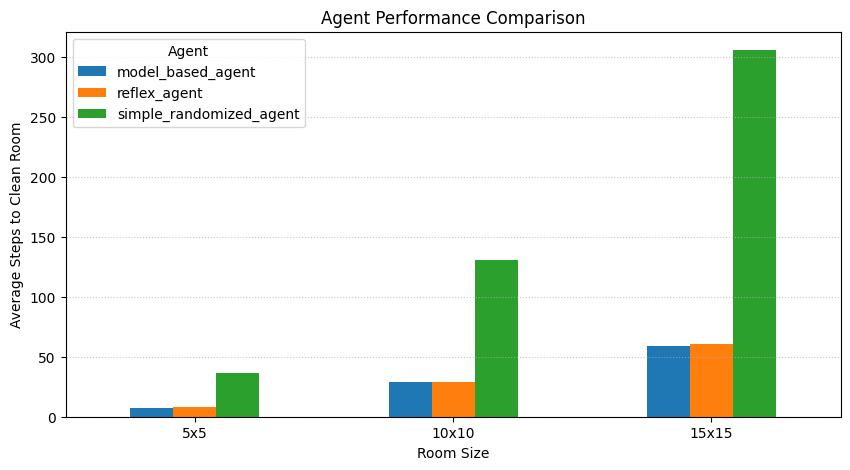

In [42]:
agents = [model_based_agent, reflex_agent, simple_randomized_agent]
df = performance_evaluation(agents)

print("Performance Results:")

df.plot(kind='bar', figsize=(10, 5), title="Agent Performance Comparison")
plt.ylabel("Average Steps to Clean Room")
plt.xlabel("Room Size")
plt.xticks(rotation=0)
plt.legend(title="Agent")
plt.grid(axis='y', linestyle='dotted', alpha=0.7)
plt.show()

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [ ]:
# For the model-based agent the rectangualar shape of the room is assumed (4 walls and 4 directions the agent can move).
# Therefore, in a rectangular room the agent will still perform in the same way as in a squared room

# However, If the room has irregular shape, the agent won't nost likely finish it is tasks as it follows the upward
# zigzag direcrion and can be stopped by an unpredicted obstacle. So, it depends on if the shape of the room will support the
# upwards east-west moevements of the robat and if there would be obstackles on its way. Generally, it might still continue it is cleaning tasks until
# it is reaches one of the top corners coming towards it in a horizontal direction, but the performance and efficiency of the agent will be unpredictable.



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
